# CRAB Popularity from Condor data
*This notebook requires a python 3 kernel, connected to the Analytix cluster*

## Source: Condor data

CRAB sets the CRAB_DataBlock classad to the condor jobs. Using the cms-htcondor-spider and the MonIT flow that data is stored in HDFS as Json.

We also have the CMSPrimaryDataset for all the jobs. 

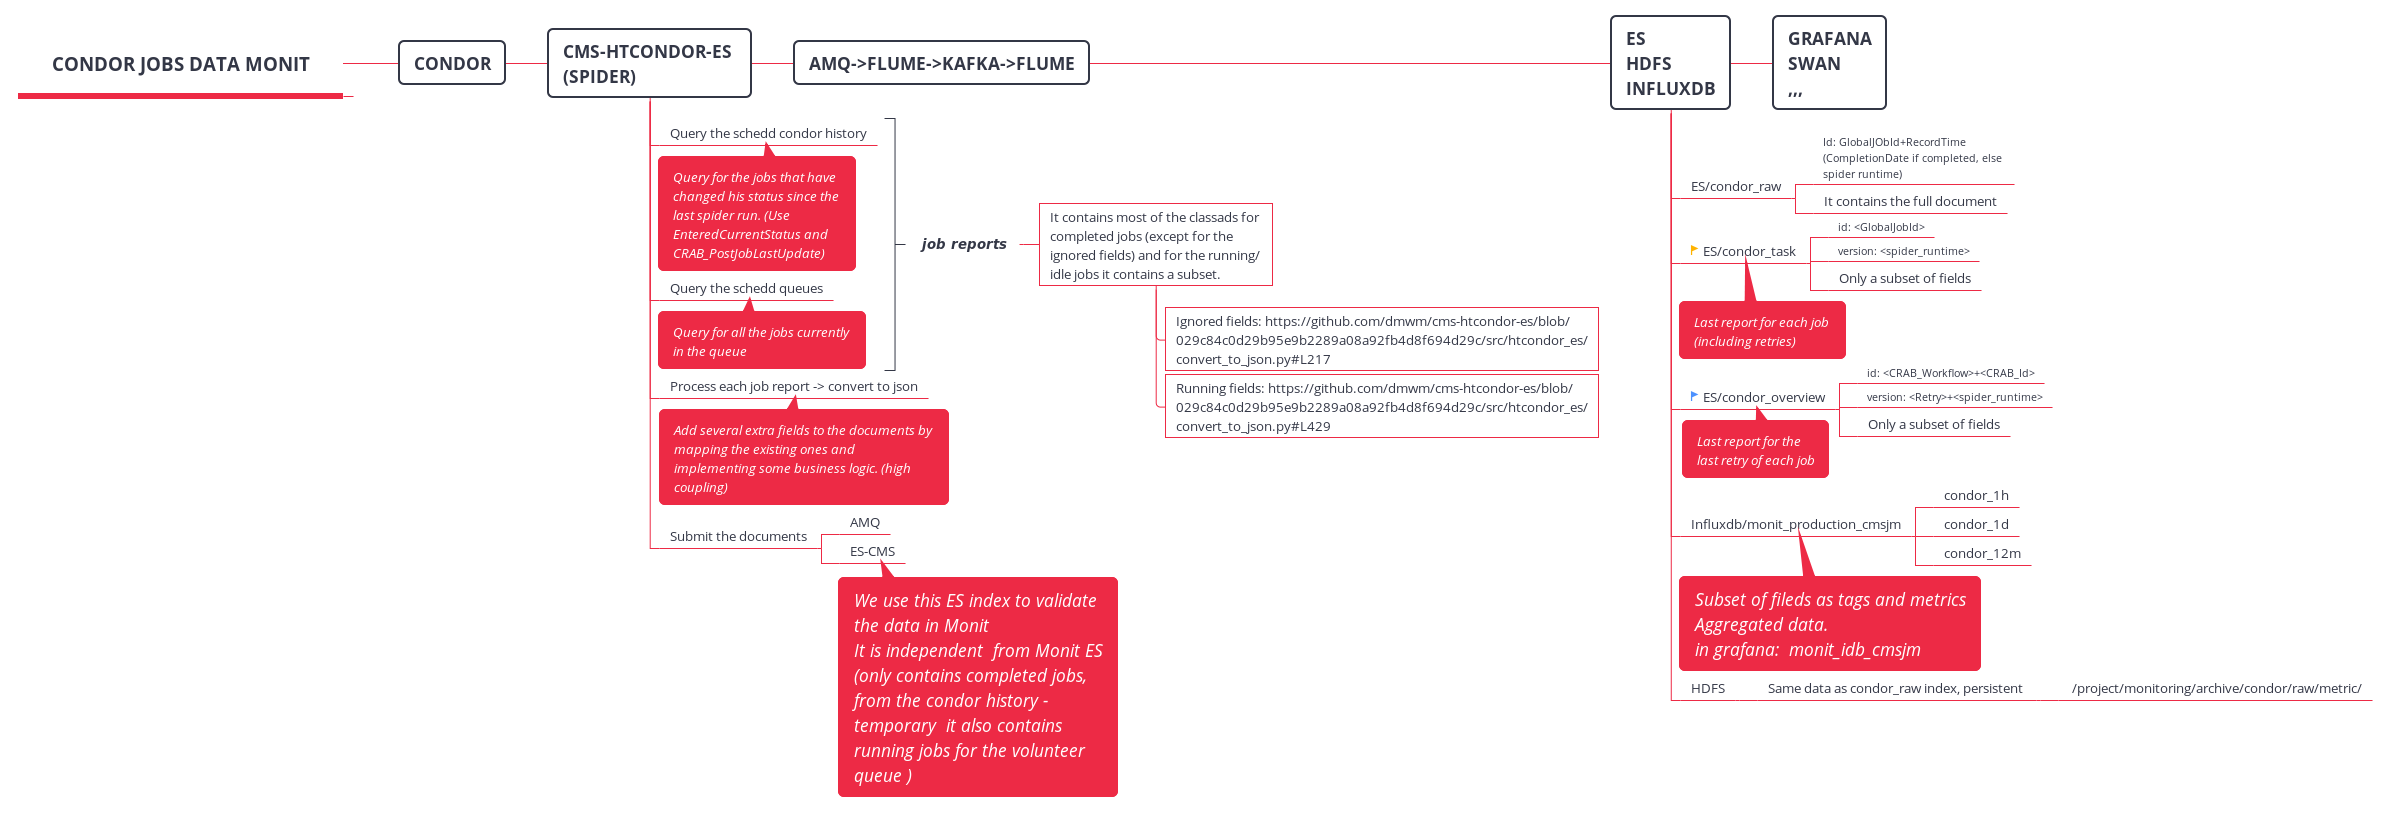

In [59]:
from datetime import datetime, timezone, timedelta
from pyspark.sql.types import StructType, LongType, StringType, StructField
from pyspark.sql.functions import input_file_name, regexp_extract, max as _max, min as _min, col, lit, count
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
start_date = datetime(2018,1,1, tzinfo=timezone.utc)
end_date = datetime(2019,1,1, tzinfo=timezone.utc)
start = int(start_date.timestamp() * 1000) 
end = int(end_date.timestamp() * 1000)

# Selecting the files and set the schema

The json documents have a flexible schema and currently they have more than 1000 different fields. We also have more than 300GB/day in data (Monit has a compaction method, so data older than a day is deduplicated and compressed, making the data weight around 80GB/day). 

By default pyspark will try to infer the schema reading all the documents, but as n this exercise we are only interested on a few fields we can set the schema. 

Also determining the actual files to read will help to reduce the processing times. 

In [61]:
schema = StructType([
    StructField('metadata', StructType([StructField("_id",StringType(), nullable=False), 
                                        StructField("timestamp",LongType(), nullable=False)])),
    StructField('data', StructType([
        StructField("GlobalJobId", StringType(), nullable=False),
        StructField("RecordTime", LongType(), nullable=False),
        StructField("Status", StringType(), nullable=True),
        StructField("CRAB_DataBlock", StringType(), nullable=True),
        StructField("CMSPrimaryPrimaryDataset", StringType(), nullable=True),
        
    ])),
])
# We are filtering by 
st_date = start_date - timedelta(days=1)
ed_date = end_date + timedelta(days=1)
days = (ed_date - st_date).days
# The candidate files (actually folders) are the folders to the specific dates,
# but if we are looking at recent days the compaction procedure could have not run yet
# so we will considerate also the .tmp folders. 
candidate_files = ["/project/monitoring/archive/condor/raw/metric/{}{{,.tmp}}".format((st_date + timedelta(days=i)).strftime("%Y/%m/%d")) for i in range(0, days) ]
FileSystem = (
    sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
 )
URI = sc._gateway.jvm.java.net.URI
Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
fs = FileSystem.get(
    URI("hdfs:///"), sc._jsc.hadoopConfiguration()
)
candidate_files = [
    url
    for url in candidate_files
    if fs.globStatus(Path(url))
    ]

In [62]:
dfs_crabdb = spark.read.option("basePath","/project/monitoring/archive/condor/raw/metric").json(candidate_files, schema=schema)\
                   .select("metadata.timestamp","data.*")\
                   .filter("Status in ('Completed', 'Removed') AND CRAB_DataBlock is not NULL  AND timestamp >= {} AND timestamp <= {}".format(start, end))\
                   .repartition("CRAB_DataBlock")\
                   .select("RecordTime","GlobalJobId", "CRAB_DataBlock","CMSPrimaryPrimaryDataset").drop_duplicates(["GlobalJobId"])\
                   .withColumnRenamed('CMSPrimaryPrimaryDataset','Dataset')


In [63]:
dfs_crabdb = dfs_crabdb.groupBy("Dataset","CRAB_DataBlock").agg(_max(col("RecordTime")), _min(col("RecordTime")), count(lit(1))).withColumnRenamed("count(1)", "count")

#### Explain the logical/pyshical execution plan. (Convert this cell to code to run it)
dfs_crabdb.explain(True)

## Process and get the data

In [65]:
crab_db_pop = dfs_crabdb.toPandas()

In [66]:
crab_db_pop = crab_db_pop.sort_values('count', ascending=False)
crab_db_pop[:10]

,Dataset,CRAB_DataBlock,max(RecordTime),min(RecordTime),count
27297,Unknown,MCFakeBlock,1546300800000,1516897464000,37916097
68027,GenericTTbar,/GenericTTbar/HC-CMSSW_9_2_6_91X_mcRun1_realis...,1546011614000,1514764073000,8523030
77922,Unknown,UserFilesFakeBlock,1546300777000,1516897663000,8363516
98669,UNKNOWN,MCFakeBlock,1516897461000,1496277564000,2494891
67546,TT_TuneCUETP8M2T4_13TeV-powheg-pythia8,/TT_TuneCUETP8M2T4_13TeV-powheg-pythia8/RunIIS...,1546300649000,1496321638000,1139936
35073,SingleMuon,/SingleMuon/Run2016H-03Feb2017_ver2-v1/MINIAOD...,1546300800000,1496288465000,931341
37727,SingleElectron,/SingleElectron/Run2016B-03Feb2017_ver2-v2/MIN...,1546293543000,1496323500000,921500
34546,SingleMuon,/SingleMuon/Run2016B-03Feb2017_ver2-v2/MINIAOD...,1546296193000,1496276015000,856920
69530,HIMinimumBias2,/HIMinimumBias2/HIRun2015-25Aug2016-v1/AOD#826...,1546246041000,1496650619000,802170
61276,SingleMuon,/SingleMuon/Run2016G-03Feb2017-v1/MINIAOD#2b4b...,1546297650000,1496288301000,763733


### Top Datablocks by number of jobs

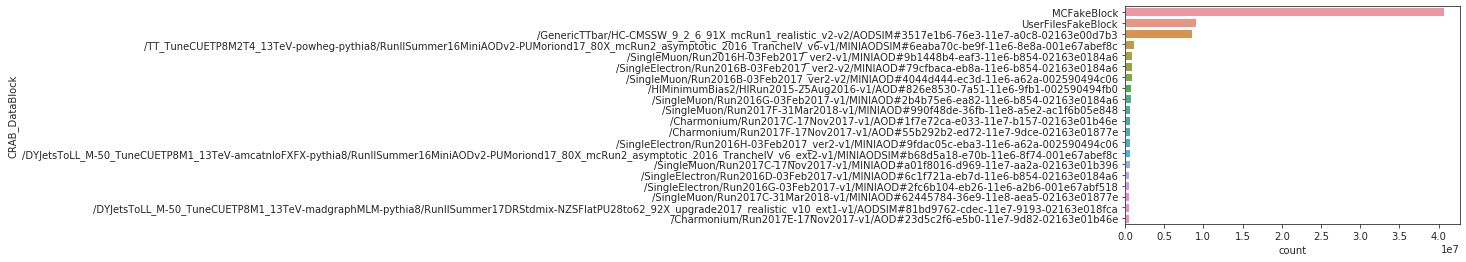

In [67]:
datablocks_pd = crab_db_pop.groupby('CRAB_DataBlock').agg({'count':'sum', 'max(RecordTime)':'max', 'min(RecordTime)':'min' }).sort_values("count", ascending=False).reset_index()
sns.barplot(data=datablocks_pd[:20],x='count', y='CRAB_DataBlock')

In [68]:
datablocks_pd[:20]

,CRAB_DataBlock,count,max(RecordTime),min(RecordTime)
0,MCFakeBlock,40647198,1546300800000,1496277564000
1,UserFilesFakeBlock,9044328,1546300777000,1496296197000
2,/GenericTTbar/HC-CMSSW_9_2_6_91X_mcRun1_realis...,8531969,1546273441000,1514764073000
3,/TT_TuneCUETP8M2T4_13TeV-powheg-pythia8/RunIIS...,1144093,1546300649000,1496321638000
4,/SingleMuon/Run2016H-03Feb2017_ver2-v1/MINIAOD...,935227,1546300800000,1496288465000
5,/SingleElectron/Run2016B-03Feb2017_ver2-v2/MIN...,922506,1546293543000,1496323500000
6,/SingleMuon/Run2016B-03Feb2017_ver2-v2/MINIAOD...,862881,1546296193000,1496276015000
7,/HIMinimumBias2/HIRun2015-25Aug2016-v1/AOD#826...,803237,1546246041000,1496650619000
8,/SingleMuon/Run2016G-03Feb2017-v1/MINIAOD#2b4b...,768841,1546297650000,1496288301000
9,/SingleMuon/Run2017F-31Mar2018-v1/MINIAOD#990f...,684954,1546300781000,1524247921000


# Bottom datablocks by number of jobs

In [69]:
datablocks_pd[-20:]

,CRAB_DataBlock,count,max(RecordTime),min(RecordTime)
97510,/ZpBaryonic_MZp2150_MChi850_tarball_Fixed/khur...,1,1520387163000,1520387163000
97511,/ZpBaryonic_MZp2200_MChi225_tarball_Fixed/khur...,1,1520385103000,1520385103000
97512,/ZpBaryonic_MZp2200_MChi150_tarball_Fixed/khur...,1,1520386025000,1520386025000
97513,/ZpBaryonic_MZp2200_MChi200_tarball_Fixed/khur...,1,1518535437000,1518535437000
97514,/ZpBaryonic_MZp2200_MChi200_tarball_Fixed/khur...,1,1520387666000,1520387666000
97515,/ZpBaryonic_MZp2200_MChi1_tarball_Fixed/khuran...,1,1518535289000,1518535289000
97516,/ZpBaryonic_MZp2200_MChi1_tarball_Fixed/khuran...,1,1520384121000,1520384121000
97517,/ZpBaryonic_MZp2200_MChi175_tarball_Fixed/khur...,1,1518535199000,1518535199000
97518,/ZpBaryonic_MZp2200_MChi175_tarball_Fixed/khur...,1,1520387530000,1520387530000
97519,/ZpBaryonic_MZp2200_MChi150_tarball_Fixed/khur...,1,1518537196000,1518537196000


# LRU datablocks

Datablocks with the lowest max(RecordTime). 
arg_min(max(RecordTime))

In [70]:
datablocks_pd = datablocks_pd.sort_values("max(RecordTime)", ascending=True)
datablocks_pd[:20]

,CRAB_DataBlock,count,max(RecordTime),min(RecordTime)
32022,/NonThDM/sundleeb-step1_dijet_nothdm_1TeV_2p0_...,64,1496291102000,1496290312000
90651,/ExpressPhysics/Run2017A-Express-v1/FEVT#25319...,1,1496293222000,1496293222000
31758,/TT_TuneCUETP8M2T4_13TeV-powheg-pythia8/PhaseI...,66,1496326413000,1496275782000
79481,/MinimumBias/Run2015B-PromptReco-v1/RECO#9c11d...,1,1496329579000,1496329579000
79480,/MinimumBias/Run2015B-PromptReco-v1/RECO#3c72f...,1,1496330290000,1496330290000
62052,/SingleMuon/Run2016G-03Feb2017-v1/MINIAOD#b4eb...,5,1496333254000,1496327922000
26211,/VBFHToTauTau_M125_13TeV_powheg_pythia8/PhaseI...,107,1496338235000,1496330762000
40878,/SUSYGluGluToBBHToTauTau_M-3200_TuneCUETP8M1_1...,33,1496341937000,1496334763000
90571,/ExpressPhysics/Run2017A-Express-v1/FEVT#fb623...,1,1496347514000,1496347514000
25394,/JetHT/Run2016B-23Sep2016-v3/AOD#87ff0804-985f...,117,1496352511000,1496345828000


## Datasets

In [71]:
crab_ds_df = crab_db_pop.groupby('Dataset').agg({'count':'sum', 'max(RecordTime)':'max', 'min(RecordTime)':'min' })\
                       .sort_values("count",ascending=False).reset_index()

### Top Datasets

In [72]:
crab_ds_df[:20]

,Dataset,count,max(RecordTime),min(RecordTime)
0,Unknown,46279613,1546300800000,1516897464000
1,SingleMuon,19435478,1546300800000,1496276015000
2,SingleElectron,9181111,1546300688000,1496278050000
3,GenericTTbar,9062581,1546011614000,1496319714000
4,JetHT,6810718,1546300800000,1496325730000
5,Charmonium,6431857,1546300794000,1496278127000
6,DoubleEG,4030881,1546300789000,1496276471000
7,DoubleMuon,3704036,1546300800000,1496276006000
8,ZeroBias,3335569,1546300789000,1496511741000
9,UNKNOWN,3124297,1516897461000,1496277564000


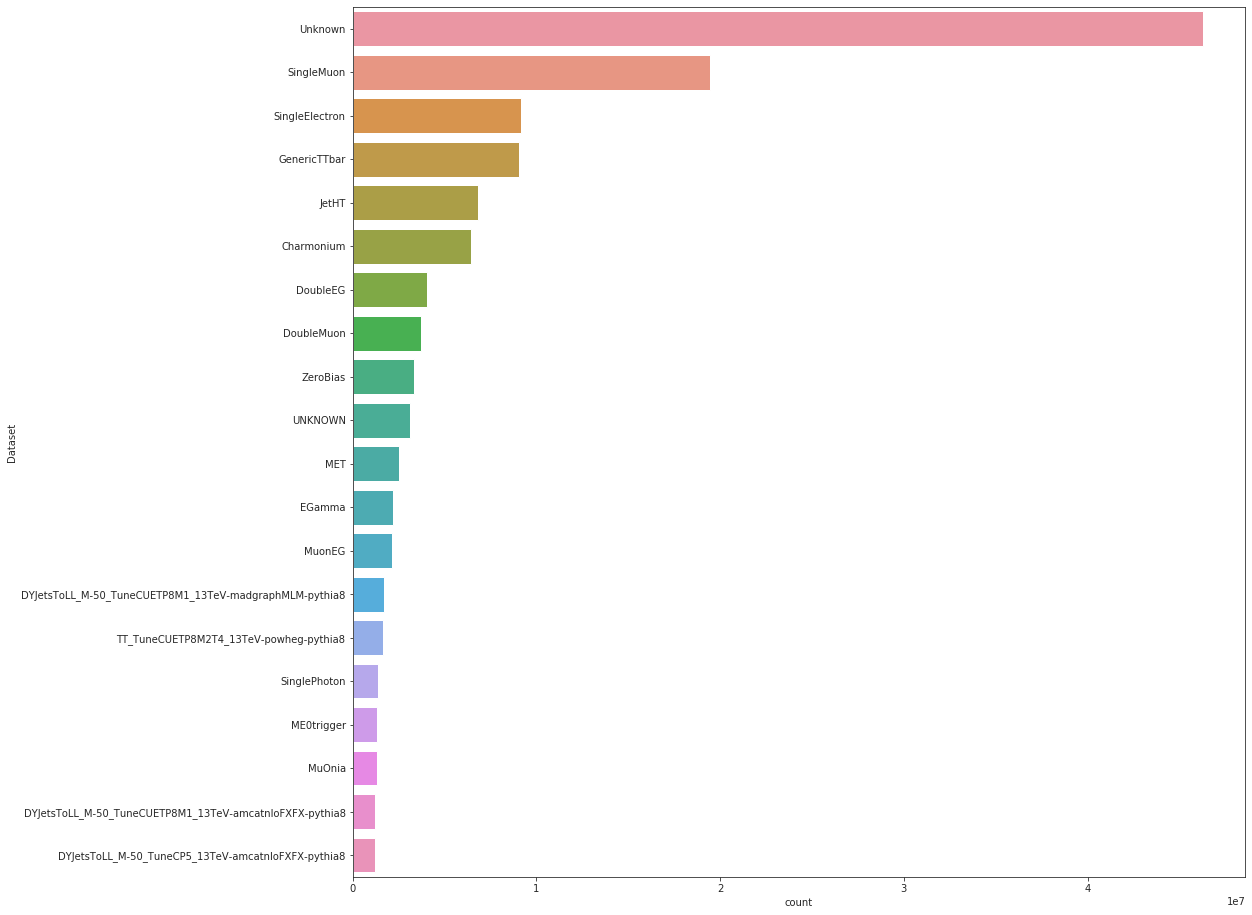

In [73]:
sns.set_style("ticks")
ax_style = sns.axes_style("whitegrid")
fig = plt.figure(figsize=(16, 16))
sns.barplot(data=crab_ds_df[0:20],x='count', y='Dataset')

### Bottom datasets

In [74]:
crab_ds_df[-20:]

,Dataset,count,max(RecordTime),min(RecordTime)
22087,ZpBaryonic_MZp7000_MChi1000,1,1516878132000,1516878132000
22088,BlackHole_BH9_MD3000_MBH6000_n6_13TeV_TuneCUET...,1,1496705862000,1496705862000
22089,BlackHole_BH9_MD3000_MBH7000_n4_13TeV_TuneCUET...,1,1496705282000,1496705282000
22090,BlackHole_BH9_MD4000_MBH6000_n4_13TeV_TuneCUET...,1,1496706172000,1496706172000
22091,BlackHole_BH9_MD4000_MBH10000_n4_13TeV_TuneCUE...,1,1496705687000,1496705687000
22092,BlackHole_BH9_MD4000_MBH5000_n6_13TeV_TuneCUET...,1,1496706648000,1496706648000
22093,BlackHole_BH9_MD4000_MBH5000_n4_13TeV_TuneCUET...,1,1496706601000,1496706601000
22094,BlackHole_BH9_MD4000_MBH5000_n2_13TeV_TuneCUET...,1,1496705854000,1496705854000
22095,BlackHole_BH9_MD4000_MBH11000_n6_13TeV_TuneCUE...,1,1496705720000,1496705720000
22096,BlackHole_BH9_MD4000_MBH11000_n4_13TeV_TuneCUE...,1,1496705639000,1496705639000


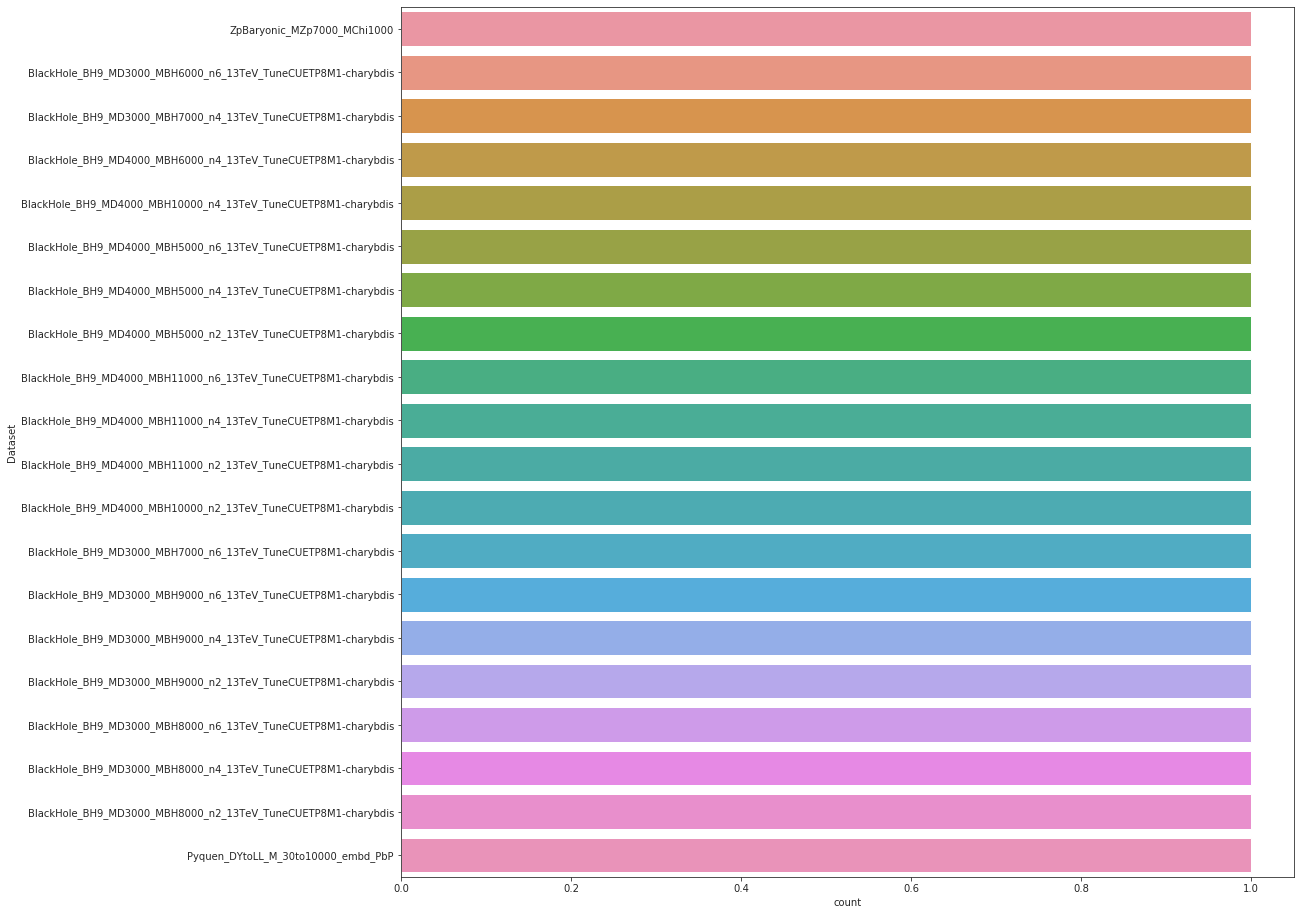

In [75]:
sns.set_style("ticks")
ax_style = sns.axes_style("whitegrid")
fig = plt.figure(figsize=(16, 16))
sns.barplot(data=crab_ds_df[-20:],x='count', y='Dataset')

### LRU Datasets

In [76]:
datablocks_pd = crab_ds_df.sort_values("max(RecordTime)", ascending=True)
datablocks_pd[:20]

,Dataset,count,max(RecordTime),min(RecordTime)
6885,NonThDM,140,1496375585000,1496290312000
14118,SUSYGluGluToBBHToTauTau_M-90_TuneCUETP8M1_13Te...,5,1496377913000,1496375962000
13817,SUSYGluGluToBBHToTauTau_M-120_TuneCUETP8M1_13T...,5,1496377935000,1496374976000
13671,SUSYGluGluToBBHToTauTau_M-100_TuneCUETP8M1_13T...,6,1496378292000,1496367661000
10750,Pythia6_Dijet220_pp502_Hydjet_MB,17,1496379631000,1496353171000
13867,SUSYGluGluToBBHToTauTau_M-130_TuneCUETP8M1_13T...,5,1496379901000,1496375035000
13781,SUSYGluGluToBBHToTauTau_M-80_TuneCUETP8M1_13Te...,6,1496380026000,1496367736000
13812,SUSYGluGluToBBHToTauTau_M-110_TuneCUETP8M1_13T...,5,1496385191000,1496374434000
11052,SingleMu_100k_91X_FlatPt05_50_eta16_28_phase2_...,15,1496389065000,1496341260000
20895,BlackHole_BH10_MD2000_MBH9000_n2_13TeV_TuneCUE...,1,1496397020000,1496397020000
